# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

	• Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
	• Контролировать добросовестность кассиров при продаже алкоголя.
    
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,AvgPool2D,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

Text(0.5, 1.0, 'Распределение картинок по возрасту')

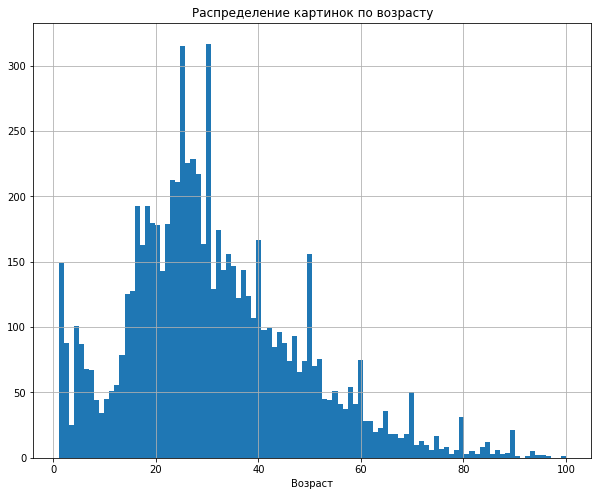

In [4]:
plt.figure(figsize=(10,8))
labels['real_age'].hist(bins=100,range=(1,100))
plt.xlabel('Возраст')
plt.title('Распределение картинок по возрасту')

По графику мы можем отметить, что есть два пика. Распределение скошено в право. Также можно отметить, что больше представлено фотографий людей в возрасте от 20 до 30 лет.

In [5]:
features,target=next(train_gen_flow)

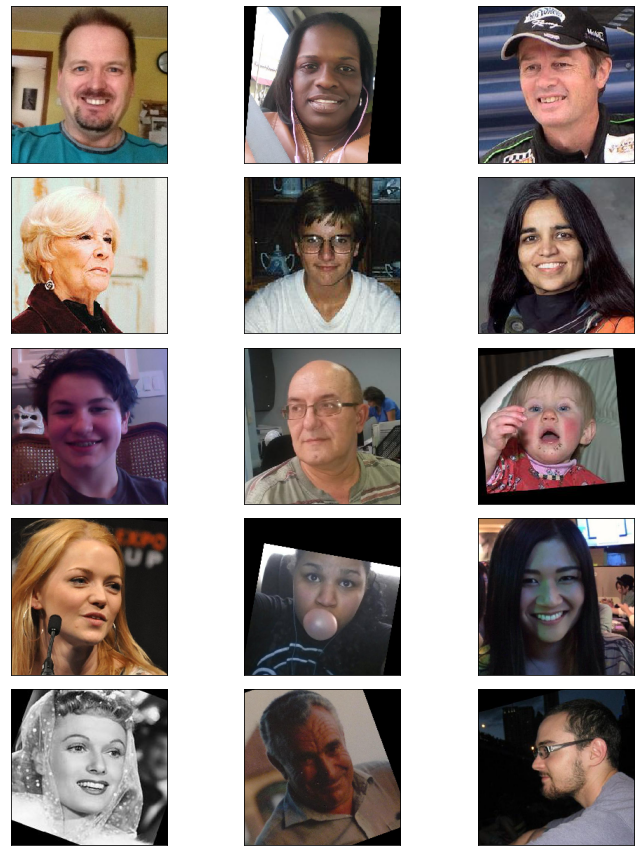

In [6]:
fig = plt.figure(figsize=(12,12))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

По итогам исследования мы можем предположить, что модель хорошо обучится на картинках с возрастом от 20 до 30. Они представлены в большом объеме. По другим возрастам количество фоторгафий уменьшается, поэтому модель может чаще ошибаться.

Фотографии ориентированы вертикально, все в одном направлении, поворачивать их не нужно. Среди цветных изображений присутсвуют черно-белые. Размер изображений одинаковый.


## Обучение модели

(Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-07-24 09:20:08.290383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-24 09:20:08.607529: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 47s - loss: 203.5508 - mae: 10.3439 - val_loss: 791.4932 - val_mae: 23.1770
Epoch 2/20
356/356 - 39s - loss: 84.2981 - mae: 6.9704 - val_loss: 130.2130 - val_mae: 8.8422
Epoch 3/20
356/356 - 39s - loss: 59.4294 - mae: 5.8954 - val_loss: 103.8528 - val_mae: 7.5117
Epoch 4/20
356/356 - 39s - loss: 44.3663 - mae: 5.0591 - val_loss: 83.2367 - val_mae: 6.7155
Epoch 5/20
356/356 - 39s - loss: 34.9704 - mae: 4.5843 - val_loss: 79.6368 - val_mae: 6.6688
Epoch 6/20
356/356 - 39s - loss: 26.3090 - mae: 3.9170 - val_loss: 78.1147 - val_mae: 6.4985
Epoch 7/20
356/356 - 38s - loss: 19.7972 - mae: 3.4302 - val_loss: 83.4683 - val_mae: 7.0209
Epoch 8/20
356/356 - 38s - loss: 16.6157 - mae: 3.0971 - val_loss: 69.4345 - val_mae: 6.1142
Epoch 9/20
356/356 - 39s - loss: 14.4754 - mae: 2.8653 - val_loss: 70.3123 - val_mae: 6.3899
Epoch 10/20
356/356 - 39s - loss: 12.9092 - mae: 2.7301 - val_loss: 61.7846 - val_mae: 5.8038
Epoch 11/20
356/356 - 39s - loss: 12.1257 - mae: 2.6700 - val_loss: 70.3862 - val_mae: 6.1593
Epoch 12/20
356/356 - 38s - loss: 11.4428 - mae: 2.5791 - val_loss: 64.8074 - val_mae: 6.0225
Epoch 13/20
356/356 - 39s - loss: 11.2542 - mae: 2.5558 - val_loss: 72.9221 - val_mae: 6.2144
Epoch 14/20
356/356 - 39s - loss: 11.1637 - mae: 2.5226 - val_loss: 64.5448 - val_mae: 5.9399
Epoch 15/20
356/356 - 39s - loss: 11.1456 - mae: 2.5564 - val_loss: 62.7235 - val_mae: 5.8217
Epoch 16/20
356/356 - 39s - loss: 10.4718 - mae: 2.4493 - val_loss: 65.4552 - val_mae: 6.0021
Epoch 17/20
356/356 - 39s - loss: 10.5570 - mae: 2.4765 - val_loss: 60.7821 - val_mae: 5.8396
Epoch 18/20
356/356 - 39s - loss: 9.3935 - mae: 2.3143 - val_loss: 69.2711 - val_mae: 6.1406
Epoch 19/20
Epoch 20/20
356/356 - 39s - loss: 9.5616 - mae: 2.3564 - val_loss: 64.8668 - val_mae: 6.1172
356/356 - 39s - loss: 9.6107 - mae: 2.3313 - val_loss: 67.7987 - val_mae: 6.3036
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 67.7987 - mae: 6.3036
Test MAE: 6.3036
```

## Анализ обученной модели

Для анализа возраста людей по фотографии была использована CCN ResNet50. Было задано 20 эпох и функция оптимизации для нахождения минимума Adam с шагом lr=0.0005.

По итогам анализа мы получили значение метрики mean absolute error для обучающей и для валидационной выборки. Лучшее значение mae для обучающей получилось 2.5564, а для тестовой лучшее значение mae - 5.8217. Модель переобучилась, т.к. есть разница mae между обучающей и тестовой выборкой. 

Точность данной модели повзволит выполнить одну из поставленных задач заказчиком - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.